In [1]:
import warnings
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import requests
from IPython.core.display import HTML

import lime
import lime.lime_tabular
import shap

from pipelines.functions import see_results, evaluate_metrics
from ml_injection_pipeline import prediction_pipeline
from tools.feed import data_info
from utils.config import DATASET_PATH, MODELS_PATH, MODEL_DATA_PATH

warnings.filterwarnings("ignore")

# Challenge 1: Regression model

![model_diagram](static/img/model_schema_xtreme.drawio.png)

<br />

The common and exclusive samples are based on the median price of the diamonds.

In [2]:
# DATA FEED
df = pd.read_csv(DATASET_PATH)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
# EXPLORATORY DATA ANALYSIS
data_info(df, sorted=True)

,index,columna,NaNs,pct_nan,dtype,count,count_unique,pct_unique
0,6,price,0,0.0,int64,5000,3179,63.58
1,5,table,0,0.0,float64,5000,78,1.56
2,4,depth,0,0.0,float64,5000,121,2.42
3,0,carat,0,0.0,float64,5000,202,4.04
4,9,z,0,0.0,float64,5000,304,6.08
5,8,y,0,0.0,float64,5000,471,9.42
6,7,x,0,0.0,float64,5000,474,9.48
7,1,cut,0,0.0,object,5000,5,0.10
8,2,color,0,0.0,object,5000,7,0.14
9,3,clarity,0,0.0,object,5000,8,0.16


In [4]:
# EXPLORATORY DATA ANALYSIS
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


In [5]:
# REMOVE OUTLIERS
outlier_sample = df[(df.price <= 0)]
df = df[(df.price > 0)].reset_index(drop=True)
display(outlier_sample)

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


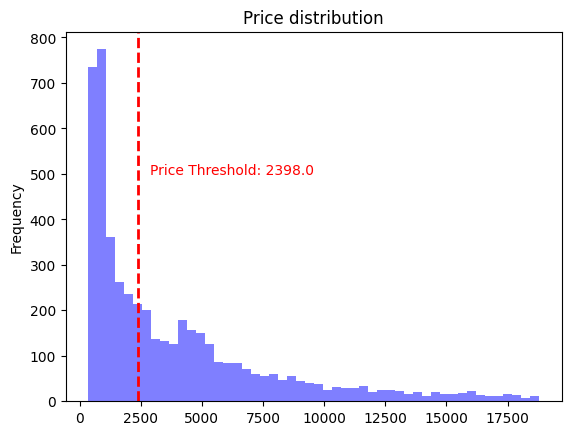

In [6]:
# Plot the histogram
price_threshold = df.price.median()
df.price.plot.hist(bins=50, alpha=0.5, color='b', title='Price distribution')

# Add a vertical line at the median price value
plt.axvline(price_threshold, color='r', linestyle='--', linewidth=2)

# Add text mentioning the median value
plt.text(price_threshold +500, 500, f"Price Threshold: {price_threshold}", color='r')

# Show the plot
plt.show()

In [7]:
# PRE CATEGORIZATION PROCESS USSING MEDIAN PRICE
exclusive_sample = df.loc[np.where(df.price >= price_threshold)[0], :]
common_sample = df.loc[np.where(df.price < price_threshold)[0], :]

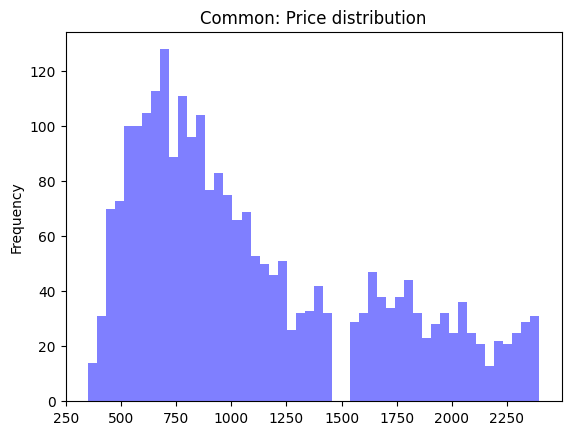

In [8]:
common_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Common: Price distribution');

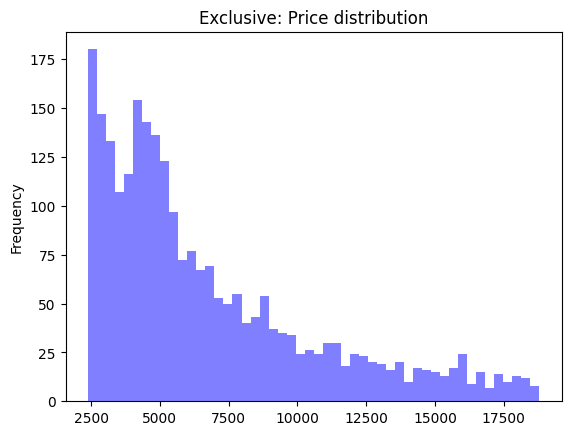

In [9]:
exclusive_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Exclusive: Price distribution');

## 1st model: Logistic Regression

In [10]:
X_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_X_test.csv'))
y_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_y_cat_test.csv'))

with open(os.path.join(MODELS_PATH, 'log_reg.pkl'), 'rb') as f:
    log_reg = pickle.load(f)

display(X_test.head())
print('shape:', X_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,2.575858,0.901561,-0.200897,2.084398,2.033043,2.201634,-0.177552,-0.315312,-0.811478,1.681494,...,-0.341073,4.377398,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
1,0.681525,-2.022046,1.558796,0.895011,0.952899,0.636074,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
2,-0.467846,-1.186730,-0.640820,-0.258605,-0.235260,-0.378641,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,-0.443040,1.848223,-0.275701,-0.321989
3,-1.042532,-0.769072,-0.200897,-1.233366,-1.216391,-1.291884,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989
4,-1.042532,0.205464,0.678949,-1.304908,-1.297402,-1.277388,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989


shape: (998, 26)


Train ROC AUC Score: 0.9989
Validation set confusion matrix


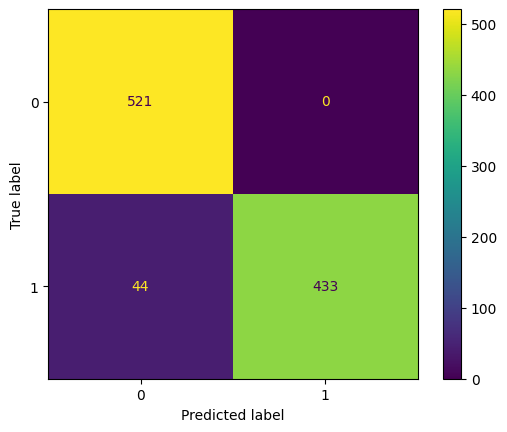

In [11]:
log_reg_train = log_reg.predict_proba(X_test)[:, 1]

# CATEGORIZATION MODEL EVALUATION
roc_auc_train = roc_auc_score(y_true=y_test, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Confusion Matrix
threshold = 0.92
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_train > threshold)
print("Validation set confusion matrix")
ConfusionMatrixDisplay(test_confusion_matrix).plot();

## 2nd model: LightGBM Common sample

Diamond with price under the median price.


In [12]:
Xc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_val.csv'))
yc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_val.csv'))
Xc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_test.csv'))
yc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_common.pkl'), 'rb') as f:
    lgbm_common = pickle.load(f)
    
display(Xc_val.head())
print('validation set shape:', Xc_val.shape)
print('test set shape:', Xc_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.933582,0.465398,-0.968536,-1.033948,-1.013368,-0.930846,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,-0.542607,2.963834,-0.379262
1,0.781185,-0.245340,-0.968536,0.929906,0.987682,0.902642,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,1.842953,-0.337401,-0.379262
2,0.855740,-1.035049,-0.015001,1.138827,1.008746,0.834735,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,3.030458,-0.462722,-0.542607,-0.337401,-0.379262
3,-0.784472,0.860253,0.461767,-0.866811,-0.971241,-0.761078,-0.133597,-0.31675,-0.949185,1.875057,...,3.364668,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,1.842953,-0.337401,-0.379262
4,-0.113476,0.465398,-0.968536,-0.031129,-0.065502,0.053805,-0.133597,-0.31675,1.053535,-0.533317,...,-0.297206,-0.19205,-0.092683,-0.214759,-0.527114,-0.329983,-0.462722,-0.542607,-0.337401,2.636701


validation set shape: (498, 26)
test set shape: (5, 26)


R2 Score: 0.95 with Variance score: 0.95
MAE Score: 73.71
Max error: 1587.44
(Total price of sample, Predicted total price, Difference)
564460 563993 -467


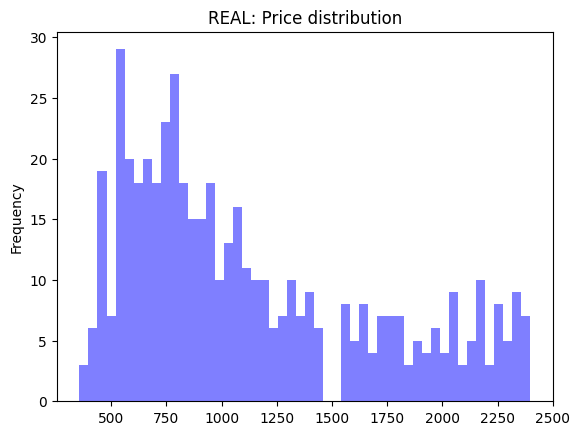

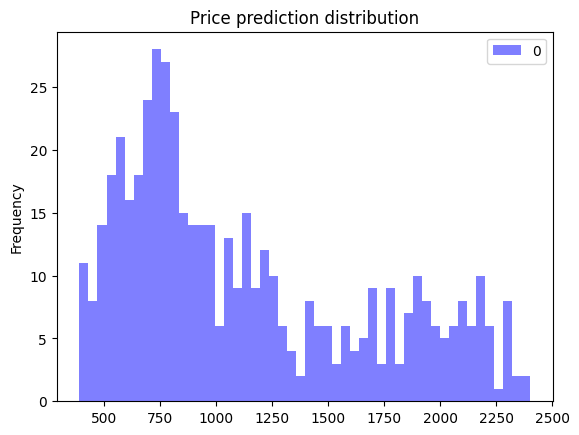

In [13]:
# MODEL PREDICTION AND EVALUATION
lgbm_pred_val = lgbm_common.predict(Xc_val)
lgbm_pred_test = lgbm_common.predict(Xc_test)

evaluate_metrics(yc_val, lgbm_pred_val)
see_results(yc_val, lgbm_pred_val)

R2 Score: 0.99 with Variance score: 0.99
MAE Score: 47.07
Max error: 120.75
(Total price of sample, Predicted total price, Difference)
5548 5412 -136


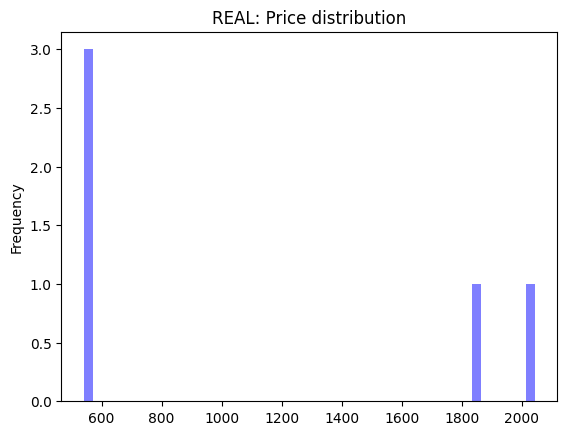

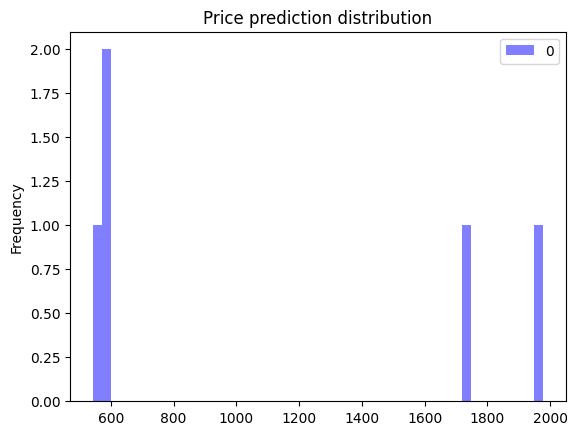

In [14]:
evaluate_metrics(yc_test, lgbm_pred_test)
see_results(yc_test, lgbm_pred_test)

## 3rd model: LightGBM Exclusive sample


In [15]:
Xe_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_val.csv'))
ye_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_val.csv'))
Xe_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_test.csv'))
ye_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_exclusive.pkl'), 'rb') as f:
    lgbm_exclusive = pickle.load(f)
    
display(Xe_val.head())
print('validation set shape:', Xe_val.shape)
print('test set shape:', Xe_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.331278,0.101041,-0.756347,-0.251117,-0.309375,-0.260185,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,1.820586,-0.392062,-0.5547,-0.195193,-0.257853
1,-0.674105,-0.084928,-1.180629,-0.532225,-0.594443,-0.578371,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,2.550620,-0.5547,-0.195193,-0.257853
2,0.222518,-0.146917,-0.332066,0.325154,0.417547,0.330733,-0.22272,-0.324983,1.423867,-0.641591,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,-0.392062,-0.5547,-0.195193,3.878185
3,-0.304907,-1.262730,0.516497,-0.012176,-0.081321,-0.351095,-0.22272,-0.324983,-0.702313,1.558625,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,-0.549274,2.550620,-0.5547,-0.195193,-0.257853
4,-0.410392,0.658947,0.516497,-0.433837,-0.494669,-0.305640,-0.22272,-0.324983,-0.702313,1.558625,...,-0.37829,-0.26553,-0.133836,-0.135769,-0.600387,1.820586,-0.392062,-0.5547,-0.195193,-0.257853


validation set shape: (497, 26)
test set shape: (5, 26)


R2 Score: 0.95 with Variance score: 0.95
MAE Score: 567.96
Max error: 7750.09
(Total price of sample, Predicted total price, Difference)
3546716 3515104 -31612


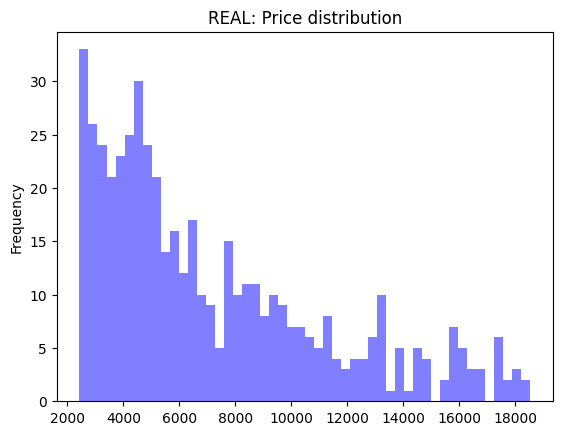

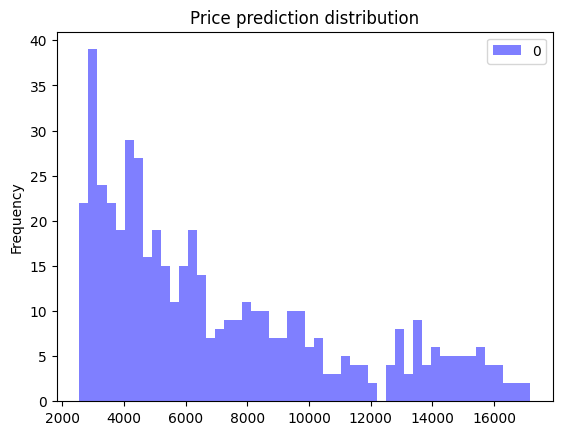

In [29]:
# MODEL PREDICTION
lgbm_pred_val = lgbm_exclusive.predict(Xe_val)
lgbm_pred_test = lgbm_exclusive.predict(Xe_test)

evaluate_metrics(ye_val, lgbm_pred_val)
see_results(ye_val, lgbm_pred_val)

R2 Score: 0.24 with Variance score: 0.32
MAE Score: 506.75
Max error: 1307.72
(Total price of sample, Predicted total price, Difference)
22270 21193 -1077


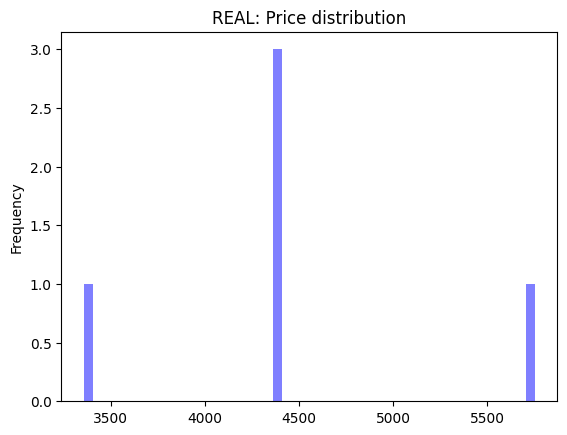

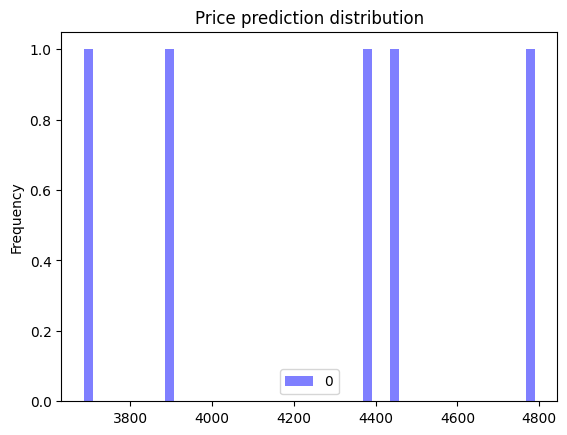

In [17]:
evaluate_metrics(ye_test, lgbm_pred_test)
see_results(ye_test, lgbm_pred_test)

# PREDICTION INTERPRETATIONS

In [18]:
# SELECT RANDOM SAMPLES
sample = df.sample(3)
sample_X = sample.drop(columns='price')
sample_y = sample.price
display(sample_X)
print(sample_y)

,carat,cut,color,clarity,depth,table,x,y,z
175,0.33,Premium,G,VVS2,61.0,58.0,4.44,4.48,2.72
3770,0.31,Ideal,E,VVS1,60.5,57.0,4.38,4.41,2.66
2138,1.31,Ideal,G,VS1,62.0,53.0,7.06,7.07,4.37


175       752
3770      942
2138    10556
Name: price, dtype: int64


In [19]:
# CREATE THE INPUTS
sample_0 = sample_X.iloc[0]
sample_1 = sample_X.iloc[1]
sample_2 = sample_X.iloc[2]

# OBTAIN THE REAL PRICE VALUE
real_0 = sample_y.iloc[0]
real_1 = sample_y.iloc[1]
real_2 = sample_y.iloc[2]

# PREDICT THE PRICE
pred_0 = prediction_pipeline(sample_0.to_dict())
pred_1 = prediction_pipeline(sample_1.to_dict())
pred_2 = prediction_pipeline(sample_2.to_dict())

In [20]:
# PRINT THE RESULTS
print("real price:", real_0)
print("prediction:", pred_0)

real price: 752
prediction: [1387.2]


In [21]:
# PRINT THE RESULTS
print("real price:", real_1)
print("prediction:", pred_1)

real price: 942
prediction: [1743.5]


In [22]:
# PRINT THE RESULTS
print("real price:", real_2)
print("prediction:", pred_2)

real price: 10556
prediction: [10476.4]


# Challenge 2: Automated pipeline

The **training pipeline** is design as a Python script that when executed, it will read the current `diamond.csv` file stored in the `.dataset/diamond` folder.
Inside the script, there is a **feature engineering** pipeline called `workflow_1` and three other pipelines for the models: `pipeline_1`, `pipeline_2`, and `pipeline_3`.

The intention is to automate the process of training and updating the models with the new data.
One possible way of making the updates automatic is to create a **Apache-Airflow** DAG for scheduling the pipeline execution.

At the moment the pipeline is executed during the container start, but if you want to run it manually these are the necessary steps to follow:

## Pipeline Local Execution

1. Create a virtual environment and install the requirements:

Linux:

```bash
$ python3 -m venv .venv
$ source .venv/bin/activate
$ pip install -r requirements.txt
```

Windows:

```bash
python -m venv .venv
.venv\Scripts\activate
pip install -r requirements.txt
```

<br />

2. Run the pipeline:
```bash
$ python ml_train_pipeline.py
```

After running the script, the models will be saved in the `.models` folder and the data in the `.models/data` folder.


# Challenge 3: Rest API

For the API, I used the FastAPI framework, which is a modern, fast (high-performance), web framework for building APIs based on standard Python type hints.

To run the API locally using virtual environment:

```bash
$ uvicorn main:app --reload
```

To run the application using Docker:

```bash
docker compose up --build
```

Your application will be available at http://localhost:8000.

In [23]:
response = requests.get('http://localhost:8000/')
HTML(response.text)

# Challenge 4: Architecture explanation

The next step is exposing the model to other businesses, but this calls for an upgrade in the training and serving infrastructure.

The current architecture is a monolithic one, where the training and serving are in the same container.

There a PROS and CONS with this situation.

The main PRO is that it is simple to deploy and maintain, but the main CONS is that it is not scalable and not fault-tolerant.

So, for creating an architecture that is scalable and fault-tolerant, we can use a microservices architecture.

The training and serving will be separated into two different containers, also we will need a container for the REST API, and a container for a PostgreSQL database, there may be also other services involved.

After the architecure is updated, our infrastructure on GCP will be something like this:


### Solution based on GPC as the cloud provider

### Training Pipeline:

1. **Data Storage**: Use **Google Cloud Storage (GCS)** for storing training data. GCS offers high scalability and durability, making it suitable for large datasets involved in machine learning.

2. **Data Processing and Transformation**: Utilize **Google Cloud Dataflow** for data processing and transformation. This managed service is based on Apache Beam and is effective for both batch and stream data processing.

3. **Machine Learning Model Training**: Employ **Google AI Platform** for model training. This integrated tool allows you to train machine learning models at scale with managed services, supporting various machine learning frameworks.

4. **Hyperparameter Tuning**: AI Platform also provides capabilities for hyperparameter tuning to improve model performance.

5. **Model Evaluation and Versioning**: Evaluate the model's performance and version control using **Cloud Source Repositories** or another VCS system. Store different versions of the models for trackability.

6. **Model Artifact Storage**: Keep the trained model artifacts in Google Cloud Storage for easy management and access.

### Serving Pipeline:

1. **Deploy REST API on Google App Engine**: Host the REST API on **Google App Engine**. App Engine is a fully managed platform that enables you to deploy, manage, and scale applications easily. It automatically scales depending on the traffic and requires minimal configuration.

2. **Integration with API Gateway for Management**: Use **Google Cloud Endpoints** to manage the API deployed on App Engine. Cloud Endpoints will serve as the front door for all requests to your API, providing functionalities like monitoring, logging, authentication, and access control.

3. **Load Balancing**: Implement **Google Cloud Load Balancing** to efficiently distribute incoming API requests across multiple instances, for example, use Google Cloud Load Balancing to distribute incoming requests across different App Engine instances or across multiple regions.

4. **Monitoring and Logging**: Leverage **Google Cloud Operations Suite** for monitoring and logging. This provides valuable insights into the application's performance and logs API requests.

5. **Data Caching (Optional)**: For optimizing frequently accessed predictions, consider using **Google Cloud Memorystore** which offers managed in-memory data stores like Redis.

6. **Security**: Ensure that all services follow GCP’s best practices for security, using tools like Identity and Access Management (IAM), Virtual Private Cloud (VPC), and data encryption.

7. **Scalability and High Availability**: Design of the architecture for high availability across multiple regions or zones. Make sure that the AI Platform Prediction service is configured to handle varying loads.

### Motivation for Choices:

- **Google Cloud Storage** is known for its performance in handling large datasets.
- **Google Cloud Dataflow** provides a robust platform for data transformation and processing.
- **AI Platform** offer a seamless experience for training and serving models.
- **Google App Engine** is selected for its ease of use, scalability, and integration capabilities with other Google Cloud services.
- **Cloud Endpoints** and **Google Cloud Load Balancing** provide efficient API management and traffic distribution.
- **Cloud Operations Suite** offers comprehensive tools for monitoring and logging.
- Security and scalability are central to this architecture, and GCP provides strong capabilities in these areas.
